In [222]:
import numpy as np
from numba import cuda, float32
import utils as u
import os
import random
import math

In [16]:
SEED = 42
np.random.seed(SEED)
random.seed(42)

## load mnist dataset

Adapted from: https://github.com/WHDY/mnist_cnn_numba_cuda/blob/master/read_mnist.py

In [17]:
data_dir = 'mnist'
train_images_path = os.path.join(data_dir, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_dir, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')
train_images = u.extract_images(train_images_path)
train_labels = u.extract_labels(train_labels_path)
test_images = u.extract_images(test_images_path)
test_labels = u.extract_labels(test_labels_path)

assert train_images.shape[0] == train_labels.shape[0]
assert test_images.shape[0] == test_labels.shape[0]

train_data_size = train_images.shape[0]
test_data_size = test_images.shape[0]

assert train_images.shape[3] == 1
assert test_images.shape[3] == 1
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1] * train_images.shape[2])
test_images = test_images.reshape(test_images.shape[0], test_images.shape[1] * test_images.shape[2])

train_data_size = train_images.shape[0]
test_data_size = test_images.shape[0]

#NORMALIZE MATRICES
train_images = train_images.astype(np.float32)
train_images = np.multiply(train_images, 1.0 / 255.0)
test_images = test_images.astype(np.float32)
test_images = np.multiply(test_images, 1.0 / 255.0)

#RANDOMIZE THE TRAIN DATA ORDER
order = np.arange(train_data_size)
np.random.shuffle(order)

#PICK TRAIN & TEST DATA
train_data = train_images[order]
train_label = train_labels[order]

test_data = test_images
test_label = test_labels

#RESHAPE DATA
train_data = train_data.reshape(-1, 28, 28, 1)
test_data = test_data.reshape(-1, 28, 28, 1)

Extracting mnist\train-images-idx3-ubyte.gz
Extracting mnist\train-labels-idx1-ubyte.gz
Extracting mnist\t10k-images-idx3-ubyte.gz
Extracting mnist\t10k-labels-idx1-ubyte.gz


In [7]:
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
import importlib
importlib.reload(u)

Plot random image and its label

label: 9


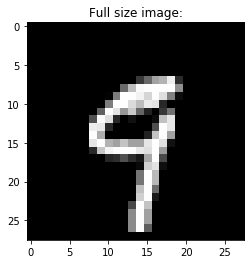

In [55]:
import matplotlib.pyplot as plt
rand_int = random.randint(0, len(train_data))
image = train_data[rand_int][:,:,0]
label = train_label[rand_int]
u.plot_image(image)

print('label: {}'.format(label))

## Apply convolution kernel to image

In [25]:
#CODE FROM: https://github.com/SkalskiP/ILearnDeepLearning.py/blob/master/01_mysteries_of_neural_networks/05_mathematics_of_cnn/Applying%20different%20filters%20to%20the%20image.ipynb
#ARTICLE LINK: https://towardsdatascience.com/gentle-dive-into-math-behind-convolutional-neural-networks-79a07dd44cf9
def simple_conv2d(image, kernel):
    return np.multiply(image, kernel).sum()

def apply_filter(image, kernel, padding = 0, stride = 1):
    # acquisition of input image and kernel dimensions
    (image_height, image_width) = image.shape
    (kernel_height, kernel_width) = kernel.shape
    
    # preparation of memory for the returned array
    output = np.zeros((
        calculate_output_dimension(image_height, kernel_height, padding, stride),
        calculate_output_dimension(image_width, kernel_width, padding, stride)
    ))
    
    (output_height, output_width) = output.shape
    
    # addition of padding
    image_with_padding = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)
    
    for x in range(output_height):
        for y in range(output_width):
            output[x, y] = simple_conv2d(crop(image_with_padding, (x * stride, y * stride), kernel.shape), kernel)
    
    return output
def crop(image, anchor, shape):
    return image[anchor[0]:anchor[0] + shape[0], anchor[1]:anchor[1] + shape[1]]
def calculate_output_dimension(image_dim, kernel_dim, padding = 0, stride = 1):
    return math.floor((image_dim + 2 * padding - kernel_dim)/stride) + 1

def post_actions(image):
    image_norm =  (image - np.min(image))/(np.max(image) - np.min(image))
    return (image_norm > 0.6).astype(int)

Apply kernel and plot image after passing it through the convolution kernel

(10, 10)


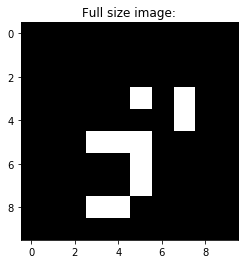

In [30]:
K1 = np.array(
    [[1, 0, 1],
    [0, 0, 0],
    [-1, 1, -1]]
)

I1 = apply_filter(image, K1,padding=1, stride = 3)
print(I1.shape)
u.plot_image(post_actions(I1))